In [ ]:
import pandas as pd
import re

def extract_numeric(value):
    match = re.search(r'[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?', str(value))
    return match.group(0) if match else None

txt_file_path = 'ElectricDevices_TEST.txt'
txt_file_path1 = 'ElectricDevices_TRAIN.txt'

ElectricDevices_TEST = pd.read_csv(txt_file_path, sep='\s+', header=None)
ElectricDevices_TRAIN = pd.read_csv(txt_file_path1, sep='\s+', header=None, low_memory=False)

# 应用extract_numeric函数来清洗所有列的数据
for column in ElectricDevices_TRAIN.columns:
    ElectricDevices_TRAIN[column] = ElectricDevices_TRAIN[column].apply(extract_numeric)
ElectricDevices_TRAIN = ElectricDevices_TRAIN.apply(pd.to_numeric, errors='coerce')

for column in ElectricDevices_TEST.columns:
    ElectricDevices_TEST[column] = ElectricDevices_TEST[column].apply(extract_numeric)
ElectricDevices_TEST = ElectricDevices_TEST.apply(pd.to_numeric, errors='coerce')

# 直接使用 .ffill() 来填充缺失值
ElectricDevices_TRAIN.ffill(inplace=True)
ElectricDevices_TEST.ffill(inplace=True)

print(ElectricDevices_TEST.head())
print(ElectricDevices_TRAIN.head())

unique_values = ElectricDevices_TEST.iloc[:, -1].value_counts()
print(unique_values)


: 

In [ ]:
# 引入必要的包
from pyspark.sql import SparkSession

# 创建或获取现有的 Spark 会话
spark = SparkSession.builder.appName("ElectricDevicesAnalysis").getOrCreate()

# 读取文本文件，假设每一行是一个数据记录
file_path = "ElectricDevices_TRAIN.txt"
data = spark.read.text(file_path)

# 显示前几行数据，确认读取成功
data.show(truncate=False)

# 如果文件是 CSV 格式的，可使用 spark.read.csv
# data = spark.read.csv(file_path, header=True, inferSchema=True)

# 对数据进行进一步处理，例如解析、清理、转换等
# 假设我们对数据进行简单操作，例如计数
record_count = data.count()
print(f"文件中共有 {record_count} 条记录")

# 你可以添加更多的转换和分析逻辑，比如过滤、聚合等

# 停止 Spark 会话
spark.stop()


: 

In [31]:
import pandas as pd
from scipy.io import arff

# 加载 ARFF 文件
def load_arff(path):
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    # 将 byte 字符串转换为普通字符串，适用于类别标签
    for col in df.select_dtypes([object]):
        df[col] = df[col].apply(lambda x: x.decode('utf-8'))
    return df

# 假设你的文件路径如下，修改为你实际的文件路径
path_test = 'ElectricDevices_TEST.arff'
path_train = 'ElectricDevices_TRAIN.arff'

df_test = load_arff(path_test)
df_train = load_arff(path_train)
unique_values = df_train.iloc[:, -1].nunique()
print("Number of unique values in the last column:", unique_values)

print(df_test.head())
print(df_train.head())








Number of unique values in the last column: 7
       att1      att2      att3      att4      att5      att6      att7  \
0 -0.196212 -0.196212 -0.196212 -0.196212 -0.196212 -0.196212 -0.196212   
1 -0.241178 -0.241178 -0.241178 -0.241178 -0.241178 -0.241178 -0.241178   
2 -0.236060 -0.236060 -0.236060 -0.236060 -0.236060 -0.236060 -0.236060   
3 -0.210315 -0.210315 -0.210315 -0.210315 -0.210315 -0.210315 -0.210315   
4 -0.171175 -0.171175 -0.171175 -0.171175 -0.171175 -0.171175 -0.171175   

       att8      att9     att10  ...     att88     att89     att90     att91  \
0 -0.196212 -0.196212 -0.196212  ... -0.196212 -0.196212 -0.196212 -0.196212   
1 -0.241178 -0.241178 -0.241178  ... -0.241178 -0.241178 -0.241178 -0.241178   
2 -0.236060 -0.236060 -0.236060  ... -0.236060 -0.236060 -0.236060 -0.236060   
3 -0.210315 -0.210315 -0.210315  ... -0.210315 -0.210315 -0.210315 -0.210315   
4 -0.171175 -0.171175 -0.171175  ... -0.171175 -0.171175 -0.171175 -0.171175   

      att92     att93 

In [32]:
import pandas as pd

def find_data_start_no_label(path):
    """
    找出实际数据开始的行号，跳过注释。
    返回行号。
    """
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            if not line.startswith('#') and not line.startswith('@'):
                return i

def load_ts_no_label(path, data_start):
    """
    从指定的起始行开始加载 .ts 文件。
    """
    with open(path, 'r') as f:
        lines = [line.strip() for line in f.readlines()[data_start:]]

    # 确定数据列的数量
    num_cols = len(lines[0].split(','))
    col_names = [f'feature_{i}' for i in range(1, num_cols + 1)]

    # 将数据行分割成二维列表
    data_lines = [line.split(',') for line in lines]

    # 创建 DataFrame
    df = pd.DataFrame(data_lines, columns=col_names)

    # 将所有特征列转换为数值类型
    for col in col_names:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

# 找到数据开始的行号
ts_path = 'ElectricDevices_TEST.ts'
ts_path2 = 'ElectricDevices_TRAIN.ts'
data_start_line = find_data_start_no_label(ts_path)
data_start_line2 = find_data_start_no_label(ts_path2)
# 从找到的行号开始加载 .ts 文件
df_ts_no_label = load_ts_no_label(ts_path, data_start_line)
df_ts_no_label2 = load_ts_no_label(ts_path2, data_start_line2)
print(df_ts_no_label.head())
print(df_ts_no_label2.head())

   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -0.196212  -0.196212  -0.196212  -0.196212  -0.196212  -0.196212   
1  -0.241178  -0.241178  -0.241178  -0.241178  -0.241178  -0.241178   
2  -0.236060  -0.236060  -0.236060  -0.236060  -0.236060  -0.236060   
3  -0.210315  -0.210315  -0.210315  -0.210315  -0.210315  -0.210315   
4  -0.171175  -0.171175  -0.171175  -0.171175  -0.171175  -0.171175   

   feature_7  feature_8  feature_9  feature_10  ...  feature_87  feature_88  \
0  -0.196212  -0.196212  -0.196212   -0.196212  ...   -0.196212   -0.196212   
1  -0.241178  -0.241178  -0.241178   -0.241178  ...   -0.241178   -0.241178   
2  -0.236060  -0.236060  -0.236060   -0.236060  ...   -0.236060   -0.236060   
3  -0.210315  -0.210315  -0.210315   -0.210315  ...   -0.210315   -0.210315   
4  -0.171175  -0.171175  -0.171175   -0.171175  ...   -0.171175   -0.171175   

   feature_89  feature_90  feature_91  feature_92  feature_93  feature_94  \
0   -0.196212   -0.19

In [33]:
import pandas as pd
import re
from scipy.io import arff

def extract_numeric(value):
    match = re.search(r'[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?', str(value))
    return match.group(0) if match else None

# 加载txt文件并清洗数据
def load_and_clean_txt(file_path):
    df = pd.read_csv(file_path, sep='\s+', header=None)
    for column in df.columns:
        df[column] = df[column].apply(extract_numeric)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.ffill(inplace=True)
    return df

# 加载arff文件
def load_arff(path):
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    # 将 byte 字符串转换为普通字符串，适用于类别标签
    for col in df.select_dtypes([object]):
        df[col] = df[col].apply(lambda x: x.decode('utf-8'))
    return df

# 加载txt和arff文件
ElectricDevices_TRAIN_txt = load_and_clean_txt('ElectricDevices_TRAIN.txt')
ElectricDevices_TRAIN_arff = load_arff('ElectricDevices_TRAIN.arff')

# 修改arff数据集的列名为与txt数据集相同
ElectricDevices_TRAIN_arff.columns = ElectricDevices_TRAIN_txt.columns[:-1].tolist() + ['label']

# 去除arff中与txt重复的特征列
duplicated_columns = ElectricDevices_TRAIN_arff.columns.intersection(ElectricDevices_TRAIN_txt.columns[:-1])
ElectricDevices_TRAIN_arff.drop(columns=duplicated_columns, inplace=True)

# 提取ElectricDevices_TRAIN_arff的标签列
labels = ElectricDevices_TRAIN_arff.iloc[:, -1]

# 删除ElectricDevices_TRAIN_txt的第一列
ElectricDevices_TRAIN_txt = ElectricDevices_TRAIN_txt.iloc[:, 1:]

# 合并txt和arff数据集，并将第一列作为索引
merged_train = pd.concat([ElectricDevices_TRAIN_txt, labels], axis=1)


# 输出合并后的数据集
print("Merged Train Dataset:")
print(merged_train.head())



/var/folders/2h/2zy84mrx0t9gwclhzy0nl5p00000gn/T/ipykernel_13177/106583344.py:11: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\s+', header=None)


Merged Train Dataset:
          1         2         3         4         5         6         7  \
0 -0.186109 -0.186109 -0.186109 -0.186109 -0.186109 -0.186109 -0.186109   
1 -0.177005 -0.177005 -0.177005 -0.177005 -0.177005 -0.177005 -0.177005   
2 -0.213535 -0.213535 -0.213535 -0.213535 -0.213535 -0.213535 -0.213535   
3 -0.171472 -0.171472 -0.171472 -0.171472 -0.171472 -0.171472 -0.171472   
4 -0.169266 -0.169266 -0.169266 -0.169266 -0.169266 -0.169266 -0.169266   

          8         9        10  ...        88        89        90        91  \
0 -0.186109 -1.860000 -0.186109  ...  2.912740 -0.186109 -0.186109 -0.186109   
1 -0.177005 -0.177005 -0.177005  ...  6.476670  1.645079 -0.177005 -0.177005   
2 -0.213535 -0.213535 -0.213535  ... -0.213535 -0.213535 -0.213535 -0.213535   
3 -0.171472 -0.171472 -0.171472  ...  0.180433  0.160882  7.355375  1.177495   
4 -0.169266 -0.169266 -0.169266  ...  6.074392  0.170933  0.190945  0.190945   

         92        93        94        95     

In [34]:
# 加载txt和arff文件
ElectricDevices_TEST_txt = load_and_clean_txt('ElectricDevices_TEST.txt')
ElectricDevices_TEST_arff = load_arff('ElectricDevices_TEST.arff')

# 修改arff数据集的列名为与txt数据集相同
ElectricDevices_TEST_arff.columns = ElectricDevices_TEST_txt.columns[:-1].tolist() + ['label']

# 去除arff中与txt重复的特征列
duplicated_columns = ElectricDevices_TEST_arff.columns.intersection(ElectricDevices_TEST_txt.columns[:-1])
ElectricDevices_TEST_arff.drop(columns=duplicated_columns, inplace=True)

# 提取ElectricDevices_TEST_arff的标签列
labels = ElectricDevices_TEST_arff.iloc[:, -1]

# 删除ElectricDevices_TEST_txt的第一列
ElectricDevices_TEST_txt = ElectricDevices_TEST_txt.iloc[:, 1:]

# 合并txt和arff数据集，并将第一列作为索引
merged_test = pd.concat([ElectricDevices_TEST_txt, labels], axis=1)

# 输出合并后的数据集
print("Merged Test Dataset:")
print(merged_test.head())


Merged Test Dataset:
          1         2         3         4         5         6         7  \
0 -0.196212 -0.196212 -0.196212 -0.196212 -0.196212 -0.196212 -0.196212   
1 -0.241178 -0.241178 -0.241178 -0.241178 -0.241178 -0.241178 -0.241178   
2 -0.236060 -0.236060 -0.236060 -0.236060 -0.236060 -0.236060 -0.236060   
3 -0.210315 -0.210315 -0.210315 -0.210315 -0.210315 -0.210315 -0.210315   
4 -0.171175 -0.171175 -0.171175 -0.171175 -0.171175 -0.171175 -0.171175   

          8         9        10  ...        88        89        90        91  \
0 -0.196212 -0.196212 -0.196212  ... -0.196212 -0.196212 -0.196212 -0.196212   
1 -0.241178 -0.241178 -0.241178  ... -0.241178 -0.241178 -0.241178 -0.241178   
2 -0.236060 -0.236060 -0.236060  ... -0.236060 -0.236060 -0.236060 -0.236060   
3 -0.210315 -0.210315 -0.210315  ... -0.210315 -0.210315 -0.210315 -0.210315   
4 -0.171175 -0.171175 -0.171175  ... -0.171175 -0.171175 -0.171175 -0.171175   

         92        93        94        95      

In [1]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# 1. 创建Spark会话
spark = SparkSession.builder.appName("DataPreprocessing").getOrCreate()

# 2. 从CSV文件读取数据，请根据需要调整路径和文件名
df = spark.read.csv("merged_train.csv", header=True, inferSchema=True)

# 3. 数据清理：删除缺失值
cleaned_df = df.dropna()

# 4. 数据转换：将某一列转换为整数
converted_df = cleaned_df.withColumn("column_name", col("column_name").cast("integer"))

# 5. 输出清理后的数据
converted_df.show()

# 关闭Spark会话
spark.stop()


/Users/guoziyao/anaconda3/lib/python3.11/site-packages/pyspark/bin/spark-class: line 71: /Library/Java/JavaVirtualMachines/temurin-21.jdk/Contents/Home/bin/java: No such file or directory
/Users/guoziyao/anaconda3/lib/python3.11/site-packages/pyspark/bin/spark-class: line 97: CMD: bad array subscript
head: illegal line count -- -1


PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

In [2]:
java -version


NameError: name 'java' is not defined

In [35]:
# 使用每列的平均值填充空缺值，排除最后一列
merged_train.iloc[:, :-1] = merged_train.iloc[:, :-1].fillna(merged_train.iloc[:, :-1].mean())
# 使用每列的平均值填充空缺值，排除最后一列
merged_test.iloc[:, :-1] = merged_test.iloc[:, :-1].fillna(merged_test.iloc[:, :-1].mean())


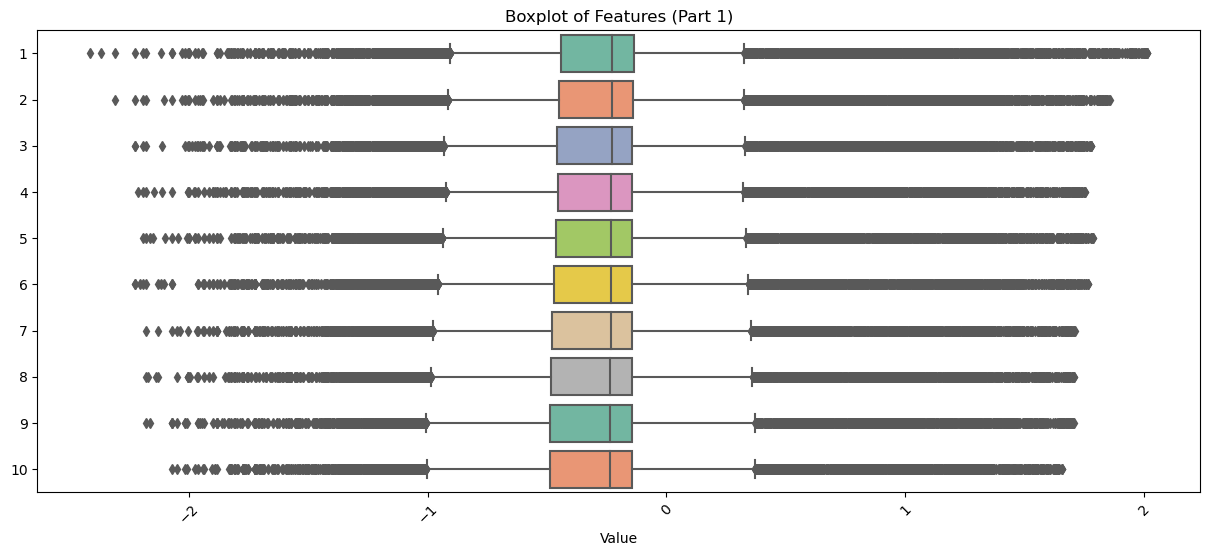

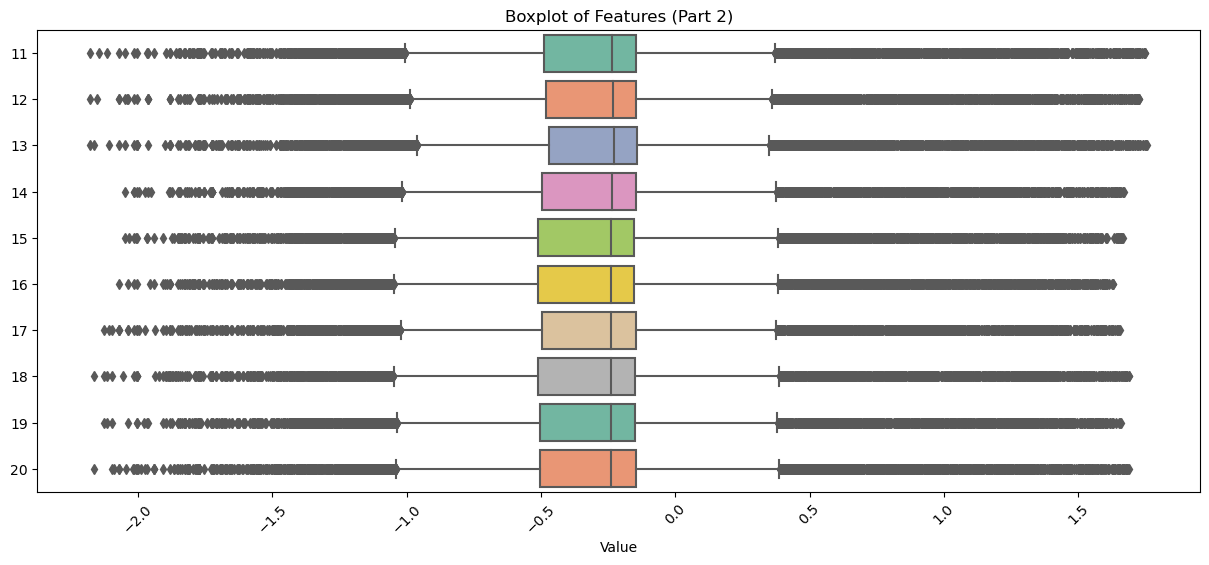

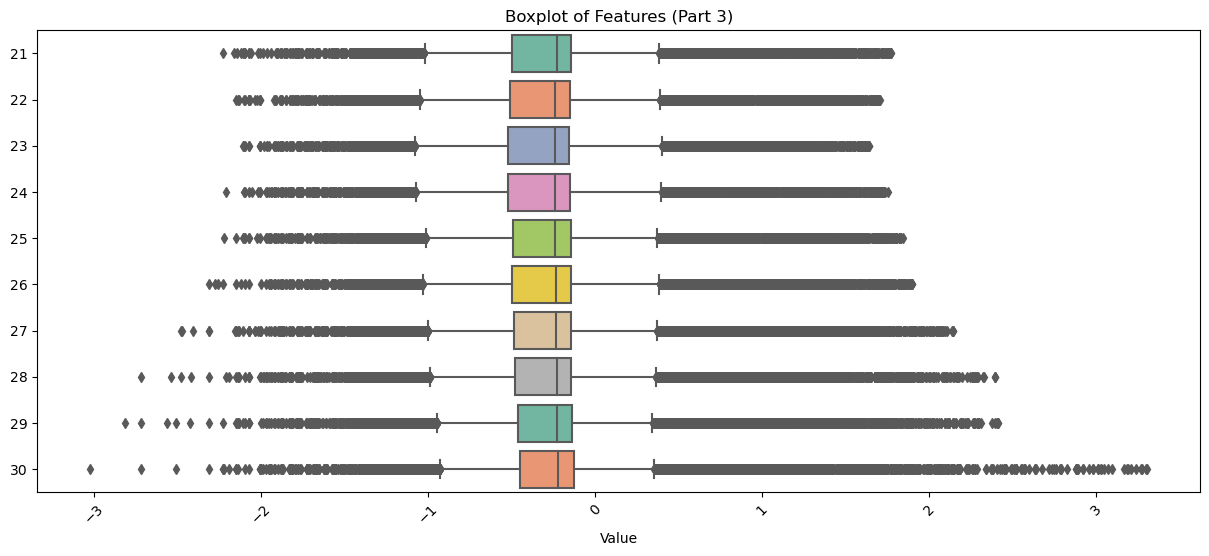

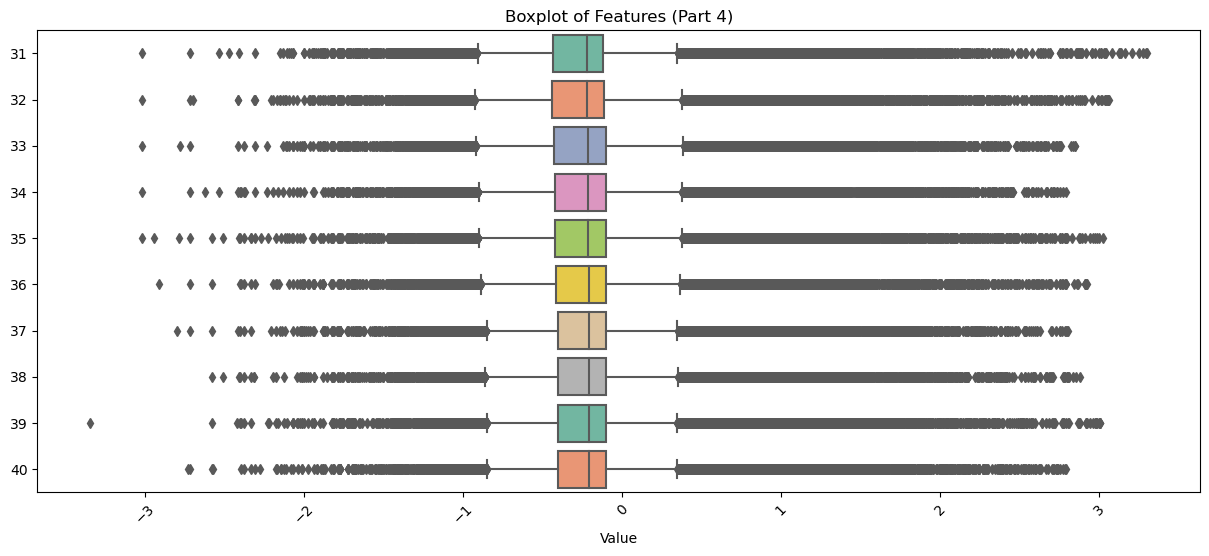

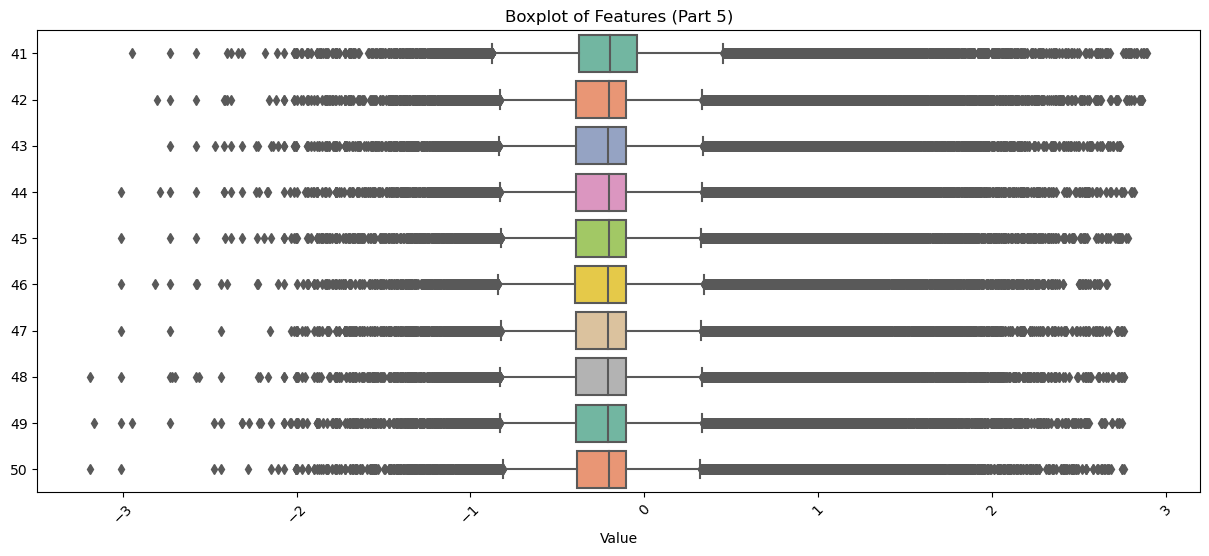

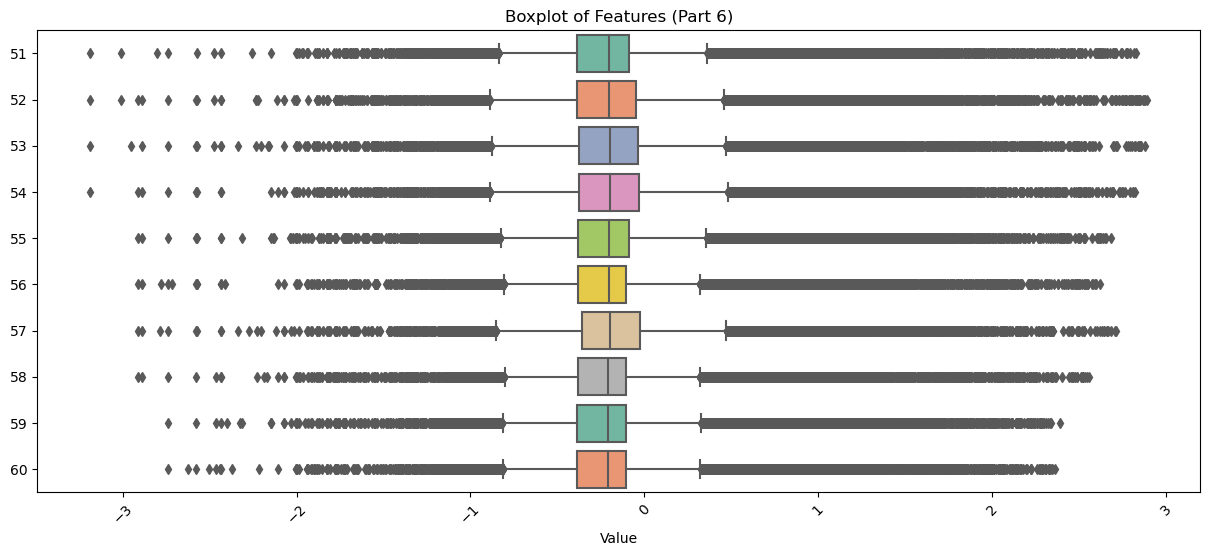

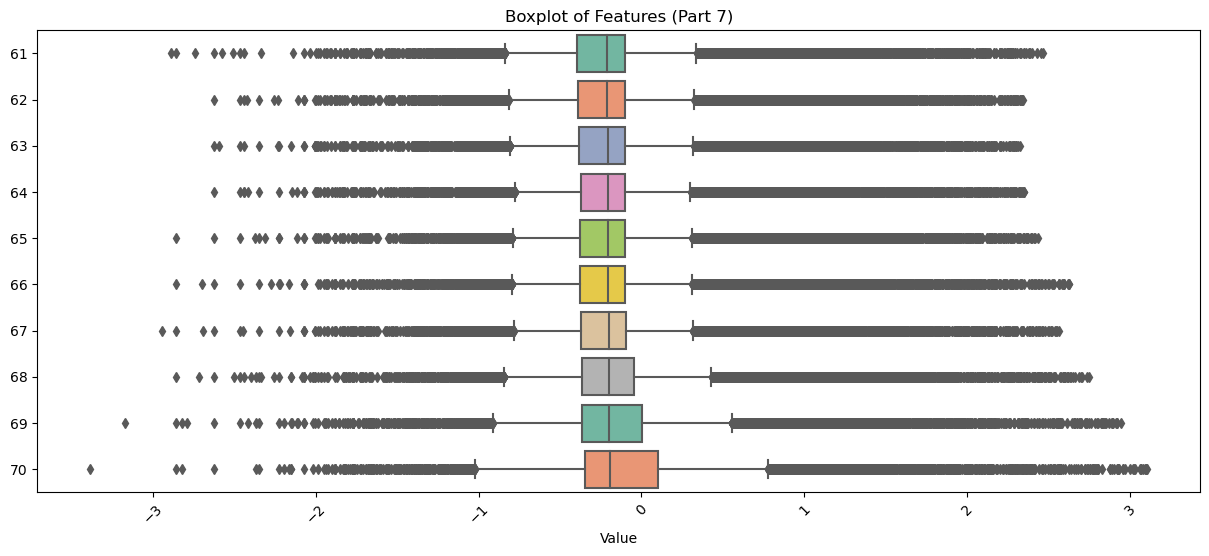

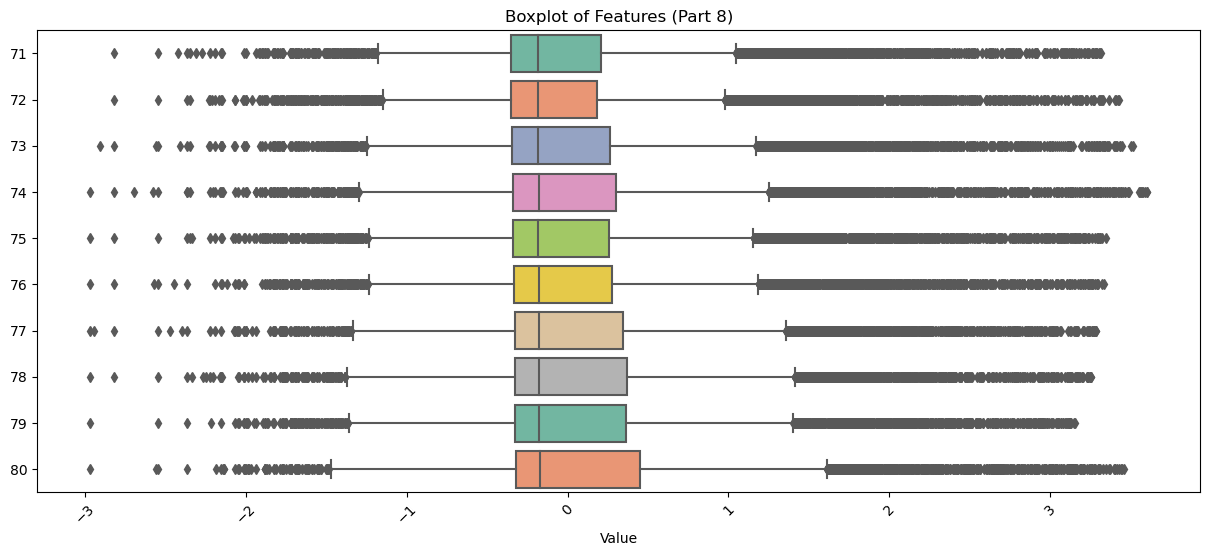

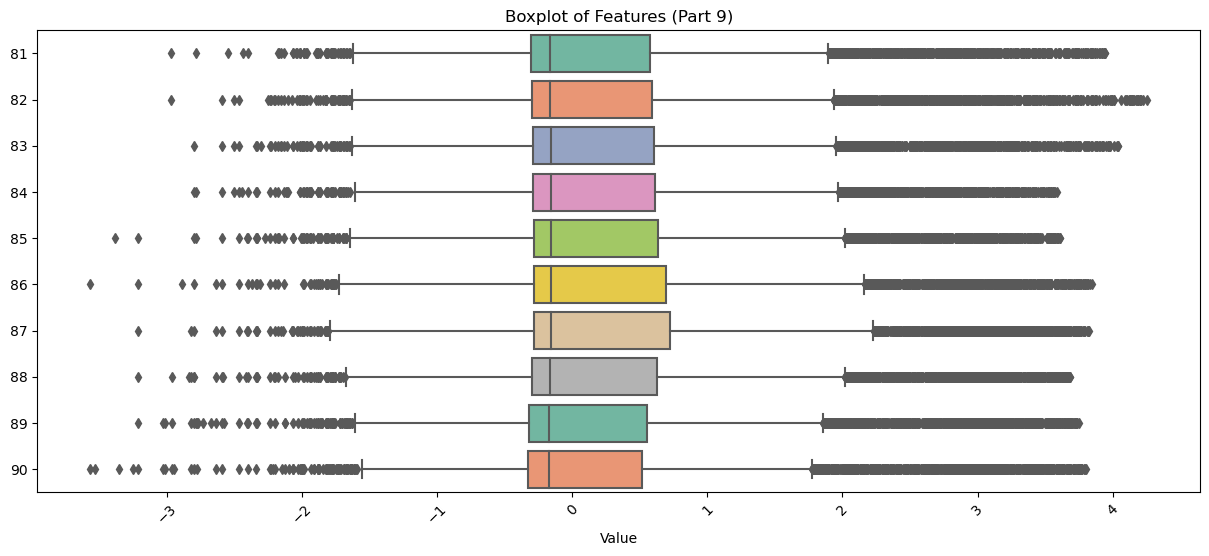

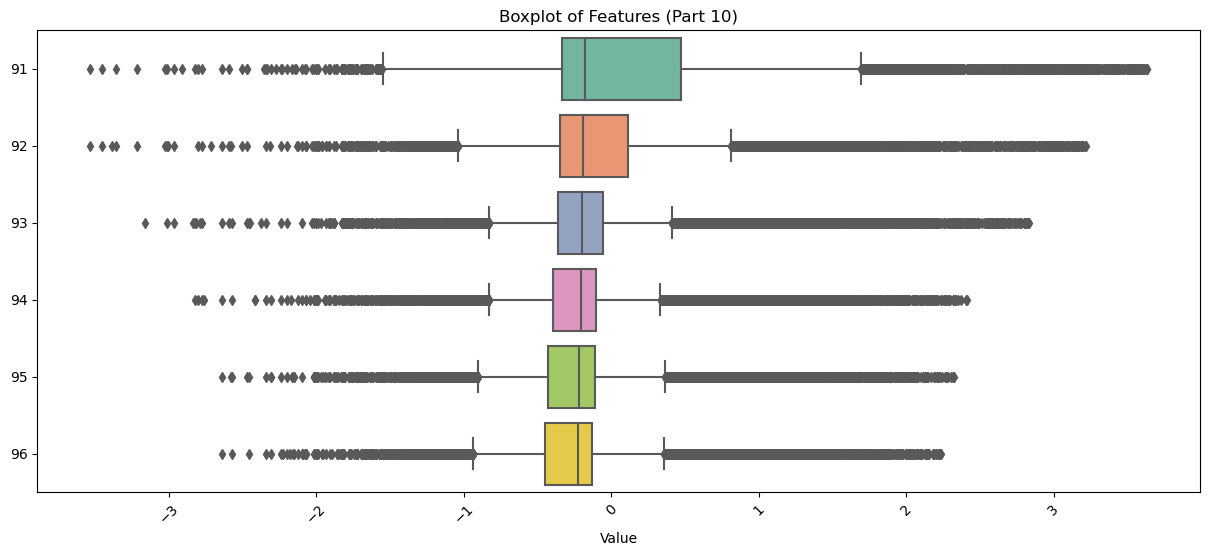

In [36]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
# 定义函数来检测和处理异常值
def handle_outliers(df):
    # 计算每列的中位数和标准差，排除最后一列
    medians = df.iloc[:, :-1].median()
    std_devs = df.iloc[:, :-1].std()
    
    # 根据Z标准化方法检测异常值
    z_scores = ((df.iloc[:, :-1] - medians) / std_devs).abs()
    
    # 将超过阈值的数值替换为中位数
    threshold = 3 # 阈值可以根据具体情况调整
    df.iloc[:, :-1] = df.iloc[:, :-1].where(z_scores <= threshold, medians, axis=1)

# 处理异常值
handle_outliers(merged_train)

# 设置每个子图显示的特征数量
features_per_subplot = 10

# 计算需要多少个子图
num_subplots = math.ceil(len(merged_train.columns[:-1]) / features_per_subplot)

# 绘制每个子图
for i in range(num_subplots):
    start_index = i * features_per_subplot
    end_index = min((i + 1) * features_per_subplot, len(merged_train.columns[:-1]))
    subset_columns = merged_train.columns[:-1][start_index:end_index]
    
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=merged_train[subset_columns], orient="h", palette="Set2")
    plt.title(f"Boxplot of Features (Part {i+1})")
    plt.xlabel("Value")
    plt.xticks(rotation=45)
    plt.show()


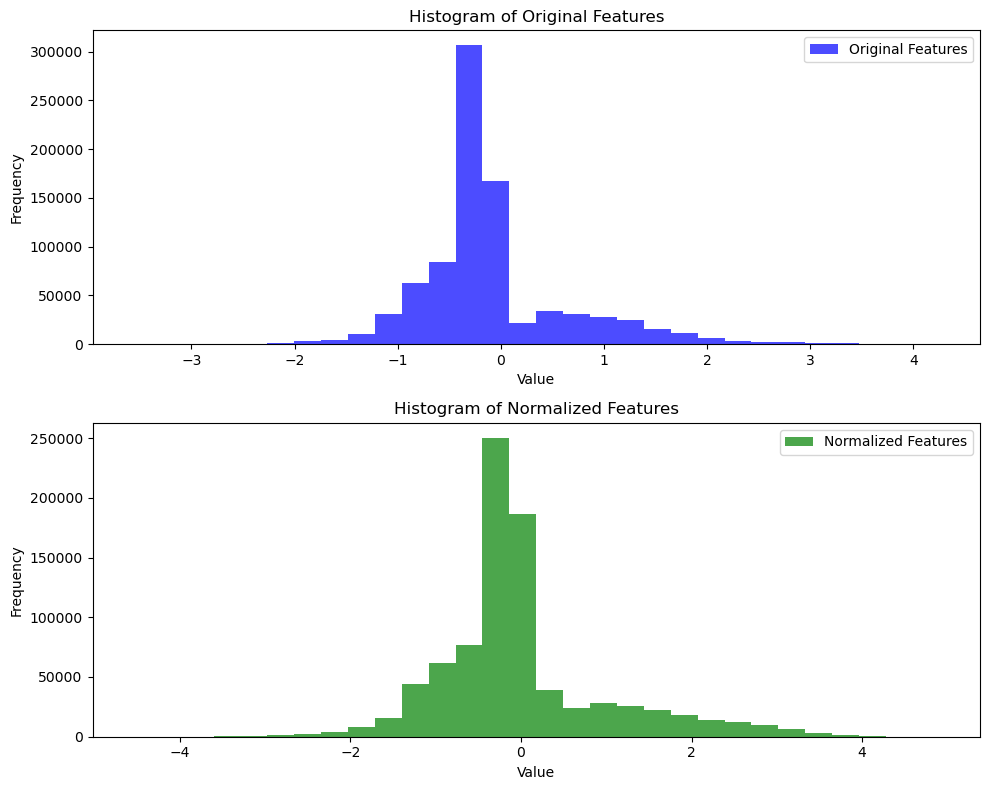

In [37]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# 原始特征数据
original_features = merged_train.iloc[:, :-1]

# 选择要标准化的特征列（假设特征列是从第二列到倒数第二列）
features_to_normalize = merged_train.iloc[:, :-1]

# 初始化标准化器
scaler = StandardScaler()

# 对特征进行标准化
normalized_features = scaler.fit_transform(features_to_normalize)

# 将标准化后的特征替换到原始 DataFrame 中
merged_train.iloc[:, :-1] = normalized_features

# 选择要标准化的特征列（假设特征列是从第二列到倒数第二列）
features_to_normalize_test = merged_test.iloc[:, :-1]
# 使用训练集的标准化器对测试集进行标准化
normalized_features_test = scaler.transform(features_to_normalize_test)
# 将标准化后的特征替换到测试集的原始 DataFrame 中
merged_test.iloc[:, :-1] = normalized_features_test


# 标准化后的特征数据
normalized_features = scaler.transform(original_features)

# 设置绘图参数
num_bins = 30
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# 绘制原始特征数据直方图
axes[0].hist(original_features.values.flatten(), bins=num_bins, color='blue', alpha=0.7, label='Original Features')
axes[0].set_title('Histogram of Original Features')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# 绘制标准化后的特征数据直方图
axes[1].hist(normalized_features.flatten(), bins=num_bins, color='green', alpha=0.7, label='Normalized Features')
axes[1].set_title('Histogram of Normalized Features')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()


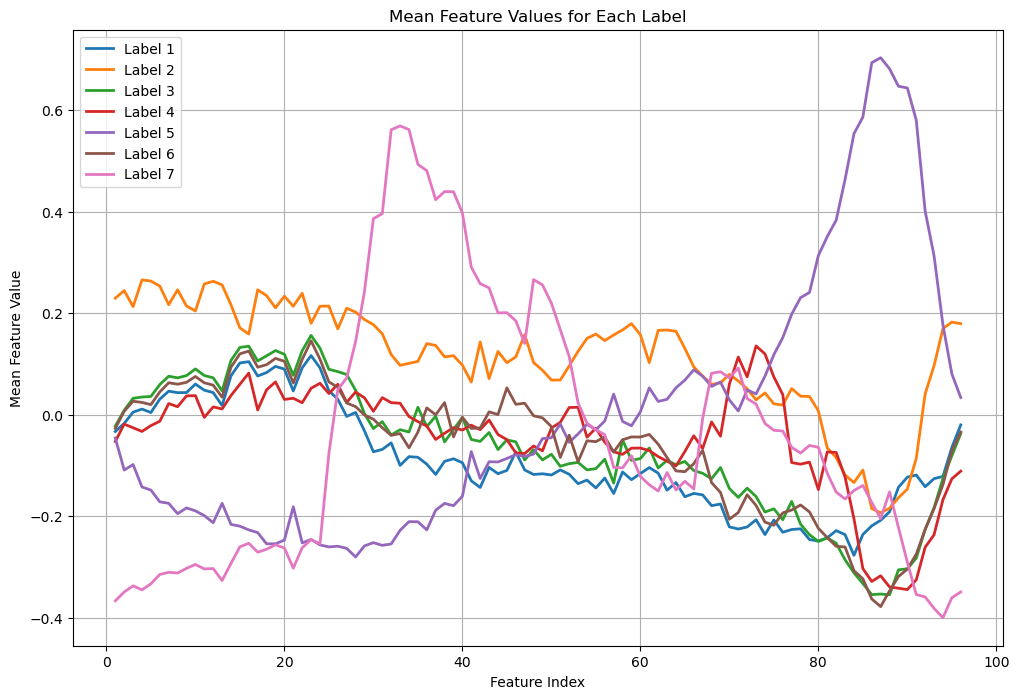

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设你已经有了数据框 merged_train
# 这里假设 merged_train 是一个 DataFrame，包含了时间、特征和标签
# 假设标签列名为 'label'

# 检查标签列中的唯一值
unique_labels = merged_train['label'].unique()

# 创建一个空字典来存储每个标签的特征值平均值
mean_feature_values = {}

# 遍历每个标签
for label in unique_labels:
    # 选择相应标签的数据
    label_data = merged_train[merged_train['label'] == label]
    # 计算特征值的平均值（排除第一列时间和最后一列标签）
    mean_values = label_data.iloc[:, :-1].mean(axis=0)  # 沿着列方向求平均值
    # 存储到字典中
    mean_feature_values[label] = mean_values

# 绘制每个标签的特征值平均值曲线
plt.figure(figsize=(12, 8))
for label, mean_values in mean_feature_values.items():
    plt.plot(range(1, len(mean_values) + 1), mean_values, label=f'Label {label}', linewidth=2)

plt.xlabel('Feature Index')
plt.ylabel('Mean Feature Value')
plt.title('Mean Feature Values for Each Label')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics.pairwise import pairwise_distances

class DtwSvm(object):
    """Classifier using dynamic time warping (DTW) as the distance measure between pairs of time series arrays,
    combined with Support Vector Machine (SVM) for classification.

    Arguments:
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default.

    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic programming function.

    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
        self.svm_model = SVC(kernel='rbf')  # 使用径向基函数作为核函数，也可以根据需要选择其他核函数
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels.
        
        Arguments:
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into the classifier.
            
        l : array of shape [n_samples]
            Training labels for input into the classifier.
        """
        self.x = x
        self.l = l
        
        # 计算训练集中每对样本之间的 DTW 距离矩阵
        dtw_dist_matrix = pairwise_distances(x, metric=self._dtw_distance)
        
        # 将 DTW 距离矩阵作为新的特征输入到 SVM 中进行训练
        self.svm_model.fit(dtw_dist_matrix, l)
        
    def _dtw_distance(self, ts_a, ts_b):
        """Returns the DTW similarity distance between two 1-D
        timeseries numpy arrays.

        Arguments:
        ---------
        ts_a, ts_b : array of shape [n_timepoints]
            Two arrays containing timeseries data
            whose DTW distance between each sample of A and B
            will be compared.
        
        Returns:
        -------
        DTW distance between A and B.
        """
        # Get lengths of two time series
        m, n = len(ts_a), len(ts_b)
        
        # Create cost matrix and initialize the first row and column
        cost = np.zeros((m, n))
        cost[0, 0] = abs(ts_a[0] - ts_b[0])
        
        for i in range(1, m):
            cost[i, 0] = cost[i-1, 0] + abs(ts_a[i] - ts_b[0])
        for j in range(1, n):
            cost[0, j] = cost[0, j-1] + abs(ts_a[0] - ts_b[j])
        
        # Populate the rest of the cost matrix
        for i in range(1, m):
            for j in range(1, n):
                cost[i, j] = abs(ts_a[i] - ts_b[j]) + min(cost[i-1, j], cost[i, j-1], cost[i-1, j-1])
        
        # Return the DTW distance
        return cost[-1, -1]
    
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data.

        Arguments:
        ---------
        x : array of shape [n_samples, n_timepoints]
            Array containing the testing data set to be classified.

        Returns:
        -------
        2 arrays representing:
            (1) the predicted class labels 
            (2) the knn label count probability.
        """
        # 计算测试集中每个样本与训练集样本的 DTW 距离
        dtw_distances = pairwise_distances(x, self.x, metric=self._dtw_distance)

        # 使用已训练的 SVM 模型对 DTW 距离进行预测
        svm_predictions = self.svm_model.predict(dtw_distances)
 

        return svm_predictions 
        


In [40]:
num_rows = merged_test.shape[0]
print("merged_test 中的行数：", num_rows)
num_rows = merged_train.shape[0]
print("merged_test 中的行数：", num_rows)


merged_test 中的行数： 7711
merged_test 中的行数： 8926


In [41]:
n = 50# 抽样数量

# 从 merged_train 中随机抽取 n 条数据作为训练集
merged_train_sample = merged_train.sample(n=n, random_state=42)

# 从 merged_test 中随机抽取 n 条数据作为测试集
merged_test_sample = merged_test.sample(n=n, random_state=42)

# 从抽样后的数据中提取特征和标签
x_train_sample = merged_train_sample.iloc[:, :-1].values  # 提取特征
y_train_sample = merged_train_sample.iloc[:, -1].values   # 提取标签

x_test_sample = merged_test_sample.iloc[:, :-1].values  # 提取特征
y_test_sample = merged_test_sample.iloc[:, -1].values   # 提取标签

m = DtwSvm(n_neighbors=1, max_warping_window=10)
# 使用抽样后的训练数据训练模型
m.fit(x_train_sample, y_train_sample)

# 对抽样后的测试数据进行预测
label_sample = m.predict(x_test_sample)
 

label_sample

array(['4', '5', '2', '4', '5', '2', '4', '2', '4', '5', '5', '5', '4',
       '2', '5', '2', '2', '5', '2', '4', '4', '5', '5', '4', '4', '5',
       '4', '5', '5', '4', '5', '2', '4', '4', '4', '4', '2', '4', '2',
       '5', '5', '5', '2', '2', '2', '2', '4', '5', '4', '4'],
      dtype=object)

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

# 提取预测标签
predicted_labels = label_sample

# 输出分类报告
print("分类报告:")
print(classification_report(y_test_sample, predicted_labels))

# 输出混淆矩阵
print("混淆矩阵:")
print(confusion_matrix(y_test_sample, predicted_labels))


分类报告:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.79      0.92      0.85        12
           3       0.00      0.00      0.00         2
           4       0.32      0.86      0.46         7
           5       0.53      0.82      0.64        11
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         7

    accuracy                           0.52        50
   macro avg       0.23      0.37      0.28        50
weighted avg       0.35      0.52      0.41        50

混淆矩阵:
[[ 0  0  0  4  0  0  0]
 [ 0 11  0  0  1  0  0]
 [ 0  0  0  2  0  0  0]
 [ 0  0  0  6  1  0  0]
 [ 0  2  0  0  9  0  0]
 [ 0  0  0  7  0  0  0]
 [ 0  1  0  0  6  0  0]]


/Users/guoziyao/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/guoziyao/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/guoziyao/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
